In [169]:
import nibabel as nb

%matplotlib inline
import cv2
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

In [1]:
import numpy as np # linear algebra
import pandas as pd # reading and processing of tables
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage.util import montage
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
CT_OFFSET = 1024
ZERO_VALUE = -2000

In [2]:
# Read an image and the image path

def read_dicom_array(in_path):
    # type: (str) -> Tuple[int, np.ndarray]
    lung_dicom = pydicom.read_file(in_path)
    
    z_location = lung_dicom.ImagePositionPatient[2]
    
    slice_array = lung_dicom.pixel_array
    slice_array[slice_array == ZERO_VALUE] = 0
    
    global affine, min_z
    affine = np.asarray([[lung_dicom.PixelSpacing[0], 0, 0, lung_dicom.ImagePositionPatient[0]], 
                         [0, lung_dicom.PixelSpacing[1], 0, lung_dicom.ImagePositionPatient[1]],
                         [0, 0, 0, 0],
                         [0, 0, 0, 1]])
    
    F11, F21, F31 = lung_dicom.ImageOrientationPatient[3:]
    F12, F22, F32 = lung_dicom.ImageOrientationPatient[:3]
    
    if z_location < min_z:
        min_z = z_location
        
    return int(lung_dicom.InstanceNumber), slice_array.astype(np.int16) - CT_OFFSET, z_location

def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        slices = [read_dicom_array(folder_name + filename) for filename in os.listdir(folder_name)]
        
        print(slices[0])
        # Sort the dicom slices in their respective order
        s_slices = sorted(slices, key = lambda x: x[2])
        
        global affine
        affine[2,2] = s_slices[1][2] - s_slices[0][2] 
        
        # Get the pixel values for all the slices
        slices = np.stack([data for pos, data, z_location in s_slices])
        return slices
    
def plot_ct_scan(scan):
    """
    show all the slices the ct as a montage
    """
    f, ax1 = plt.subplots(1,1, figsize=(12, 12))
    ax1.imshow(montage(scan), cmap=plt.cm.bone) 
    ax1.axis('off')

In [3]:
affine = None
min_z = 10000
mas_thickness = []

GT_NII = "C:\\Users\\User\\algorithms\\Lungs_db\\data_1\\preds\\Alekseev_body.nii.gz"
SAVE_FILENAME_NII = "C:\\Users\\User\\algorithms\\Lungs_db\\data_1\\preds\\Alekseev_body_pred.nii.gz"
ct_scan = read_ct_scan('C:\\Users\\User\\algorithms\\Lungs_db\\data_1\\CT_06_09_20_Alekseev\\') 
print('Scan Dimensions',ct_scan.shape)

affine[2, 3] = min_z

# Умножаем элементы на -1, а саму картинку мы повернем на 270 градусов, уж не знаю зач, но надо
affine[0, 0] *= -1
affine[1, 1] *= -1
affine[0, 3] *= -1
affine[1, 3] *= -1
print(affine)

(1, array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       ...,
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16), "1633.99")
Scan Dimensions (774, 512, 512)
[[-7.48046875e-01  0.00000000e+00  0.00000000e+00  1.87670000e+02]
 [ 0.00000000e+00 -7.48046875e-01  0.00000000e+00  2.18000000e+01]
 [ 0.00000000e+00  0.00000000e+00  4.50000000e-01  1.28614000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [4]:
ct_scan.shape

(774, 512, 512)

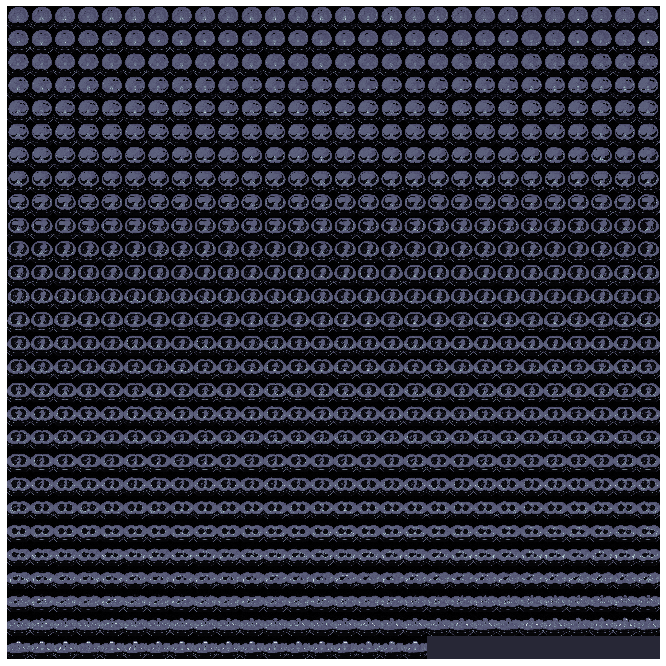

In [5]:
plot_ct_scan(ct_scan)

In [6]:
plt.imshow(cv2.rotate(ct_scan[200], cv2.ROTATE_90_COUNTERCLOCKWISE))

NameError: name 'cv2' is not defined

In [ ]:
ct_scan[20].min()

In [ ]:
nb.load(GT_NII).get_fdata().shape

In [ ]:
affine

In [ ]:
def get_segmented_lungs(in_im, plot=False, treshold=-1700):
    im = in_im.copy() # don't change the input
    im = cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
    im = cv2.flip(im, 0)
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(3, 3, figsize=(10, 10))
        plots = plots.flatten()
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im > treshold
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
        plots[0].set_title('First Threshold')
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
        plots[1].set_title('Remove Border')
    '''
    Step 3: Label the image.
    '''
    label_image = label(binary)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.gist_earth)
        plots[2].set_title('Label Components')
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(label_image, selem)
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone)
        plots[3].set_title('Erosion')
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    label_binary = label(binary)
    areas = [r.area for r in regionprops(label_binary)]
    areas.sort()
    if len(areas) > 1:
        for region in regionprops(label_binary):
            if region.area < areas[-1]:
                for coordinates in region.coords:                
                       label_binary[coordinates[0], coordinates[1]] = 0
    binary = label_binary > 0
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
        plots[4].set_title('Keep Biggest 2')
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary_er = binary_erosion(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary_er, cmap=plt.cm.bone)
        plots[5].set_title('Erosion')
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary_er, selem)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
        plots[6].set_title('Close Image')
    
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary_1 = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(binary_1, cmap=plt.cm.bone) 
        plots[7].set_title('Fill holes')
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = (binary_1 == 0)
    im[get_high_vals] = ZERO_VALUE # minimum value
    if plot == True:
        plots[8].axis('off')
        plots[8].imshow(im, cmap=plt.cm.bone) 
        plots[8].set_title('Binary Masked Input')
        
    return (binary_er > 0) * 1.0

In [ ]:
get_segmented_lungs(ct_scan[500], True, -800)

In [ ]:
masks = []
for sc in ct_scan:
    mask = get_segmented_lungs(sc, False, -800)
    masks.append(mask.reshape(mask.shape[0], mask.shape[1]))

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(14, 7))
nib_data = nb.load(GT_NII).get_fdata()

axis[0].imshow(masks[309])
axis[1].imshow(nib_data[:,:,309])

In [ ]:
def inverse_segmentation(img, plot=True):
    """
    Функция инверсии разметки, закрашивает все, что было неразмечено и удаляет все, что конектится с краями
    """
    new_img = (img == 0.) * 1.
    cleared = clear_border(new_img)
    if plot == True:
        plt.imshow(cleared, cmap=plt.cm.bone) 
    return cleared

In [ ]:
inverse_segmentation(masks[309])

In [237]:
((result>0)*1.).max()

1.0

In [238]:
result = np.moveaxis(np.asarray(masks), [0], [2])

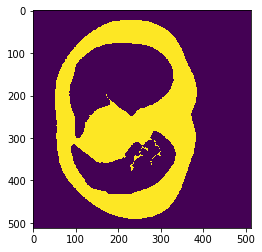

In [240]:
plt.imshow(result[:,:,309])

In [261]:
nb.load(GT_NII).affine

array([[-7.48046875e-01,  0.00000000e+00,  0.00000000e+00,
         1.87669998e+02],
       [ 0.00000000e+00, -7.48046875e-01,  0.00000000e+00,
         2.17999992e+01],
       [ 0.00000000e+00,  0.00000000e+00,  4.49951172e-01,
         1.28614001e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [262]:
affine

array([[-7.48046875e-01,  0.00000000e+00,  0.00000000e+00,
         1.87670000e+02],
       [ 0.00000000e+00, -7.48046875e-01,  0.00000000e+00,
         2.18000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  4.50000000e-01,
         1.28614000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [263]:
new_image = nb.Nifti1Image(result.astype('float'), affine)
nb.save(new_image, SAVE_FILENAME_NII)

## Вычисление ошибки

In [245]:
def calc_dice_score(gt, pred, k=1):
    smoothing = 0.01
    dice = (np.sum(pred[gt==k])*2.0 + smoothing) / ((np.sum(pred) + np.sum(gt)) + smoothing)
    return dice

Dice score: 0.7413983240848419


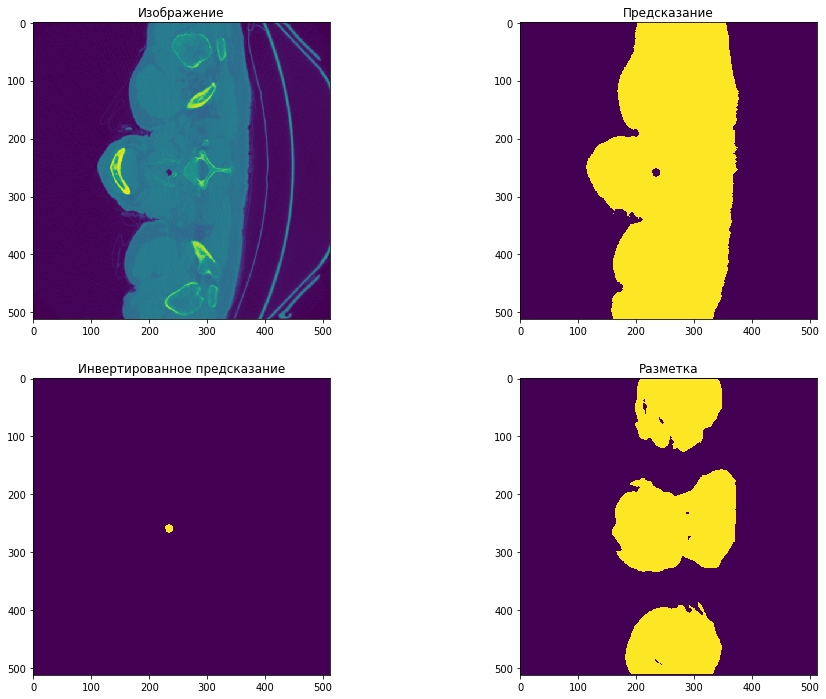

In [259]:
fig, axis = plt.subplots(2, 2, figsize=(16, 12))
nib_data = nb.load(GT_NII).get_fdata()

sl = 765
pred = result[:,:,sl].copy()
pred = inverse_segmentation(pred)

axis[0][0].imshow(cv2.flip(cv2.rotate(ct_scan[sl], cv2.ROTATE_90_COUNTERCLOCKWISE), 0))
axis[0][0].set_title('Изображение')
axis[0][1].imshow(result[:,:,sl])
axis[0][1].set_title('Предсказание')
axis[1][0].imshow(pred)
axis[1][0].set_title('Инвертированное предсказание')
axis[1][1].imshow(nib_data[:,:,sl])
axis[1][1].set_title('Разметка')
print("Dice score:", calc_dice_score(nib_data[:,:,sl], result[:,:,sl]))
plt.show()

In [249]:
dice_mas = []

for i in range(result.shape[2]):
    pred = result[:,:,i].copy()
    #pred = inverse_segmentation(pred, False)
    dice_mas.append(calc_dice_score(nib_data[:,:,i], pred))
    print("Dice score for {} slice:".format(i), dice_mas[-1])

Dice score for 0 slice: 8.043369203274521e-08
Dice score for 1 slice: 0.18562801529543882
Dice score for 2 slice: 0.225978753749268
Dice score for 3 slice: 0.2738843387786682
Dice score for 4 slice: 0.31989675317910937
Dice score for 5 slice: 0.3702065794087656
Dice score for 6 slice: 0.41826684576351825
Dice score for 7 slice: 0.4586124664233313
Dice score for 8 slice: 0.49136295857110907
Dice score for 9 slice: 0.520632408536507
Dice score for 10 slice: 0.5505807681610172
Dice score for 11 slice: 0.5800930601468925
Dice score for 12 slice: 0.6124325420331894
Dice score for 13 slice: 0.6401788265432065
Dice score for 14 slice: 0.6667887124205268
Dice score for 15 slice: 0.6927232413287874
Dice score for 16 slice: 0.717424586025571
Dice score for 17 slice: 0.7402781851770921
Dice score for 18 slice: 0.760517279889079
Dice score for 19 slice: 0.7775436298008416
Dice score for 20 slice: 0.7931449317175404
Dice score for 21 slice: 0.8097436183192979
Dice score for 22 slice: 0.824163075599

Dice score for 197 slice: 0.9406198394455773
Dice score for 198 slice: 0.9406515811987948
Dice score for 199 slice: 0.9414500969601604
Dice score for 200 slice: 0.9415594095716829
Dice score for 201 slice: 0.9424245614922528
Dice score for 202 slice: 0.9425571615320836
Dice score for 203 slice: 0.943372267940669
Dice score for 204 slice: 0.9440601214985467
Dice score for 205 slice: 0.9441409382883634
Dice score for 206 slice: 0.9440553116645483
Dice score for 207 slice: 0.9441493833623084
Dice score for 208 slice: 0.94397651240175
Dice score for 209 slice: 0.9437673031770225
Dice score for 210 slice: 0.9441356522381201
Dice score for 211 slice: 0.9441607722266017
Dice score for 212 slice: 0.9440490320827609
Dice score for 213 slice: 0.9442109808069337
Dice score for 214 slice: 0.9446640344908844
Dice score for 215 slice: 0.9447587746910138
Dice score for 216 slice: 0.9453499950154218
Dice score for 217 slice: 0.9452914356386635
Dice score for 218 slice: 0.9453500155131194
Dice score fo

Dice score for 389 slice: 0.9400424538109307
Dice score for 390 slice: 0.9397501229490126
Dice score for 391 slice: 0.9395000883843867
Dice score for 392 slice: 0.9394246822566604
Dice score for 393 slice: 0.9394271167714197
Dice score for 394 slice: 0.9392493040752884
Dice score for 395 slice: 0.9394032105625777
Dice score for 396 slice: 0.9394408425211656
Dice score for 397 slice: 0.9392726222110416
Dice score for 398 slice: 0.9394839639355066
Dice score for 399 slice: 0.9395963176014925
Dice score for 400 slice: 0.9398000198742485
Dice score for 401 slice: 0.9388428559741195
Dice score for 402 slice: 0.9395444017018812
Dice score for 403 slice: 0.939895387730218
Dice score for 404 slice: 0.9400635248628026
Dice score for 405 slice: 0.9403735891318941
Dice score for 406 slice: 0.9406064238633377
Dice score for 407 slice: 0.9406912598513725
Dice score for 408 slice: 0.9406960066690928
Dice score for 409 slice: 0.9410336256258359
Dice score for 410 slice: 0.9398652188485757
Dice score 

Dice score for 595 slice: 0.9590795722774953
Dice score for 596 slice: 0.9592121749479302
Dice score for 597 slice: 0.9592712243585413
Dice score for 598 slice: 0.9593051136434231
Dice score for 599 slice: 0.959431565624965
Dice score for 600 slice: 0.9595283890515292
Dice score for 601 slice: 0.960093234546284
Dice score for 602 slice: 0.9603121834778844
Dice score for 603 slice: 0.9608525973230396
Dice score for 604 slice: 0.9609602657776009
Dice score for 605 slice: 0.9612308937201283
Dice score for 606 slice: 0.9615276474059891
Dice score for 607 slice: 0.9616945384736983
Dice score for 608 slice: 0.9617040483357041
Dice score for 609 slice: 0.9618283752585286
Dice score for 610 slice: 0.9618838773022711
Dice score for 611 slice: 0.9620846355677103
Dice score for 612 slice: 0.9622149465992933
Dice score for 613 slice: 0.9623595464822201
Dice score for 614 slice: 0.9627020327010474
Dice score for 615 slice: 0.9629803079086618
Dice score for 616 slice: 0.9629673959189418
Dice score f

In [250]:
np.asarray(dice_mas).mean()

0.9311881788394688